In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

WINDOW_SIZE = 25

In [2]:
df_normal = pd.read_csv("data/iscx/dataset_normal.csv")
df_attack = pd.read_csv("data/iscx/dataset_attack.csv")

df_normal = df_normal.drop(['ip.src','ip.dst','frame.protocols'], axis='columns')
df_attack = df_attack.drop(['ip.src','ip.dst','frame.protocols'], axis='columns')

print(df_normal.describe(include='all'))

y_normal = df_normal['class']
y_attack = df_attack['class']
X_normal = df_normal.drop(['class'], axis='columns').values
X_attack = df_attack.drop(['class'], axis='columns').values

X = np.concatenate((X_normal,X_attack))
y = np.concatenate((y_normal,y_attack))

print(X.shape)
print(y.shape)

        frame.encap_type     frame.len    ip.hdr_len        ip.len  \
count          2668936.0  2.668936e+06  2.668936e+06  2.668936e+06   
unique               NaN           NaN           NaN           NaN   
top                  NaN           NaN           NaN           NaN   
freq                 NaN           NaN           NaN           NaN   
mean                 1.0  7.333625e+02  1.996394e+01  7.170713e+02   
std                  0.0  6.881926e+02  8.493158e-01  6.904383e+02   
min                  1.0  6.000000e+01  0.000000e+00  0.000000e+00   
25%                  1.0  6.000000e+01  2.000000e+01  4.000000e+01   
50%                  1.0  2.430000e+02  2.000000e+01  2.290000e+02   
75%                  1.0  1.484000e+03  2.000000e+01  1.470000e+03   
max                  1.0  1.514000e+03  2.400000e+01  1.500000e+03   

        ip.flags.rb   ip.flags.df  p.flags.mf  ip.frag_offset        ip.ttl  \
count     2668936.0  2.668936e+06   2668936.0       2668936.0  2.668936e+06   
u

In [4]:
for i in range(0,len(y)):
  if y[i] =="attack":
    y[i]=0
  else:
    y[i]=1

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [5]:
n = len(X)

newX = []
newY = []
tradNewX = []

i = 0
while i + WINDOW_SIZE < n:
    temp = X[i:i+WINDOW_SIZE]

    newX.append(temp)
    tradNewX.append(np.ravel(temp))
    newY.append(y[i])

    i += WINDOW_SIZE

newX = np.array(newX)
newY = np.array(newY)

print(newX.shape)
print(newY.shape)


(226359, 25, 26)
(226359,)


In [13]:
try:
    X_train = np.load('data/X_train.npy')
    X_test = np.load('data/X_test.npy')
    y_train = np.load('data/y_train.npy')
    y_test = np.load('data/y_test.npy')
except:
    print('Gerando novos dados')
    X_train, X_test, y_train, y_test = train_test_split(newX, newY, shuffle=True, test_size=0.6)

    np.save('data/X_train.npy', X_train)
    np.save('data/X_test.npy', X_test)
    np.save('data/y_train.npy', y_train)
    np.save('data/y_test.npy', y_test)

In [8]:
classifiers = [
                ("KNN", KNeighborsClassifier(n_neighbors=5)),
                ("NC", NearestCentroid()),
                ("XGBoost", XGBClassifier()),
                ("Random Forest", RandomForestClassifier()),
              ]

try:
  X_train_trad = np.load('data/X_train_trad.npy')
  X_test_trad = np.load('data/X_test_trad.npy')
  y_train_trad = np.load('data/y_train_trad.npy')
  y_test_trad = np.load('data/y_test_trad.npy')
except:
  print('Gerando novos dados')
  X_train_trad = [np.ravel(x) for x in X_train]
  X_test_trad = [np.ravel(x) for x in X_test]
  y_train_trad = [np.ravel(y) for y in y_train]
  y_test_trad = [np.ravel(y) for y in y_test]

  np.save('data/X_train_trad.npy', X_train_trad)
  np.save('data/X_test_trad.npy', X_test_trad)
  np.save('data/y_train_trad.npy', y_train_trad)
  np.save('data/y_test_trad.npy', y_test_trad)

for name, clf in classifiers:
    
    if os.path.exists("models/"+ name + '.pkl'):
      with open("models/"+ name + '.pkl', 'rb') as file:
        loaded_clf = pickle.load(file)
      predictions = loaded_clf.predict(X_test_trad)
    elif os.path.exists("models/"+ name + '.json'):
      loaded_clf = XGBClassifier()
      loaded_clf.load_model("models/"+ name + '.json')
      predictions = loaded_clf.predict(X_test_trad)
    else:
      print(f'Gerando novo modelo {name}')
      clf.fit(X_train_trad, y_train_trad)

      if name == "XGBoost":
        clf.save_model("models/"+ name + '.json')
      else:
        with open("models/"+ name + '.pkl', 'wb') as file:
          pickle.dump(clf, file)
      
      predictions = clf.predict(X_test_trad)

    print(f"Para o modelo: {name}")
    print(classification_report(y_test_trad, predictions))
    print("\n")

Para o modelo: KNN
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     71897
           1       0.80      0.96      0.87     63919

    accuracy                           0.87    135816
   macro avg       0.88      0.87      0.87    135816
weighted avg       0.88      0.87      0.87    135816



Para o modelo: NC
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     71897
           1       0.71      0.93      0.80     63919

    accuracy                           0.79    135816
   macro avg       0.81      0.80      0.79    135816
weighted avg       0.82      0.79      0.78    135816



Para o modelo: XGBoost
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71897
           1       0.98      0.99      0.99     63919

    accuracy                           0.99    135816
   macro avg       0.99      0.99      0.99    135816
weighted a

In [3]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

model = create_baseline()

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

history = model.fit(X_train, y_train, epochs=40, validation_split=0.2, verbose = 1)



Epoch 1/40


2264/2264 [==============================] - 22s 8ms/step - loss: 0.3184 - accuracy: 0.9223 - val_loss: 0.2464 - val_accuracy: 0.9230
Epoch 2/40
2264/2264 [==============================] - 17s 7ms/step - loss: 0.2206 - accuracy: 0.9376 - val_loss: 0.2156 - val_accuracy: 0.9409
Epoch 3/40
2264/2264 [==============================] - 15s 7ms/step - loss: 0.1955 - accuracy: 0.9439 - val_loss: 0.1766 - val_accuracy: 0.9456
Epoch 4/40
2264/2264 [==============================] - 16s 7ms/step - loss: 0.1850 - accuracy: 0.9459 - val_loss: 0.1832 - val_accuracy: 0.9443
Epoch 5/40
2264/2264 [==============================] - 16s 7ms/step - loss: 0.1791 - accuracy: 0.9471 - val_loss: 0.1743 - val_accuracy: 0.9478
Epoch 6/40
2264/2264 [==============================] - 16s 7ms/step - loss: 0.1720 - accuracy: 0.9492 - val_loss: 0.1717 - val_accuracy: 0.9484
Epoch 7/40
2264/2264 [==============================] - 16s 7ms/step - loss: 0.1692 - accuracy: 0.9504 - val_loss: 0.1865 - va

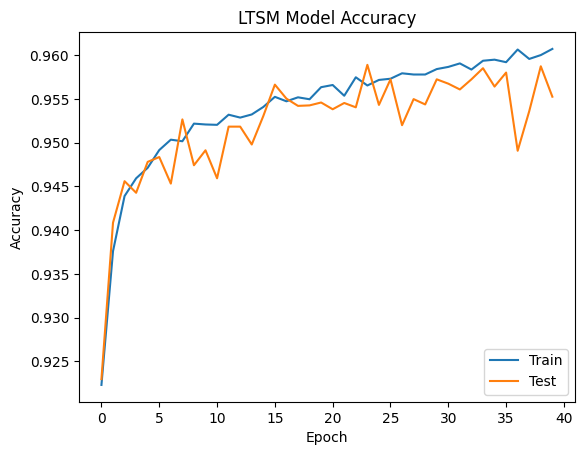

In [4]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LTSM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

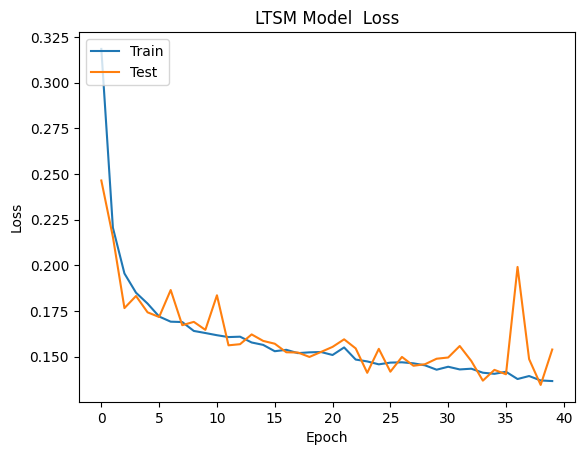

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LTSM Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [3]:
if os.path.exists('ddos_classification.keras'):
    model = load_model('ddos_classification.keras')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

predictions = model.predict(X_test)

predictions = predictions.flatten().round()

print(classification_report(y_test, predictions))



4245/4245 [==============================] - 14s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     71897
           1       0.92      0.99      0.96     63919

    accuracy                           0.96    135816
   macro avg       0.96      0.96      0.96    135816
weighted avg       0.96      0.96      0.96    135816



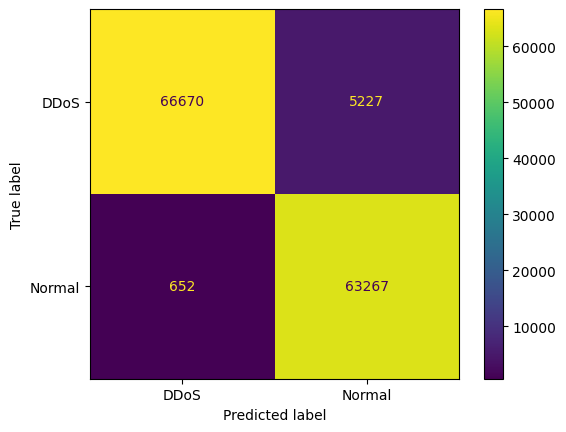

In [4]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=["DDoS","Normal"])
disp.plot()

In [8]:
model.save("ddos_classification.keras")

# Comparação entre os modelos

In [10]:
xgboost_model = XGBClassifier()
xgboost_model.load_model('XGBoost.json')

models = [
    ('LSTM', load_model('ddos_classification.keras')),
    ('XGBoost', xgboost_model),
]

for name in ['KNN', 'Random Forest']:
    with open(name + '.pkl', 'rb') as file:
        clf = pickle.load(file)

    models.append((name, clf))

## Matrizes de Confusão

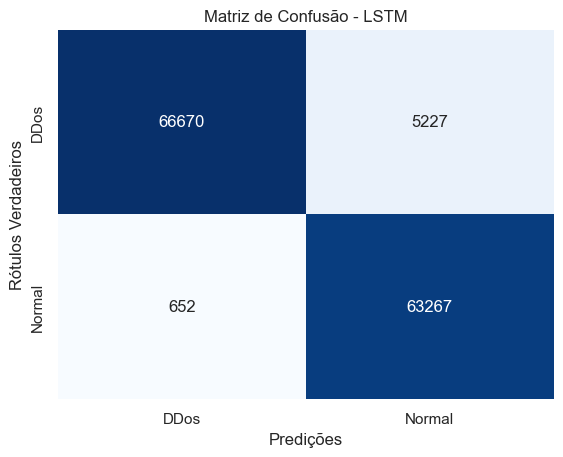

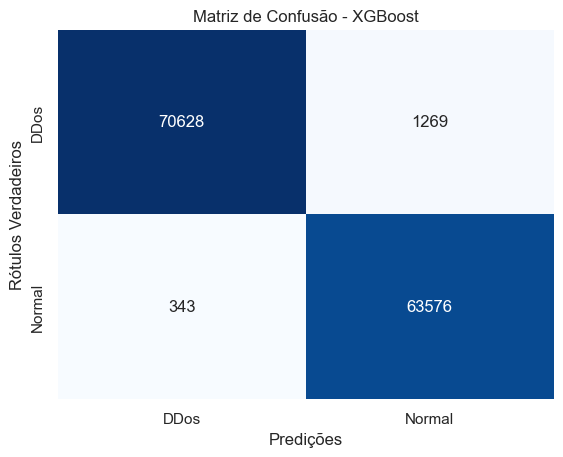

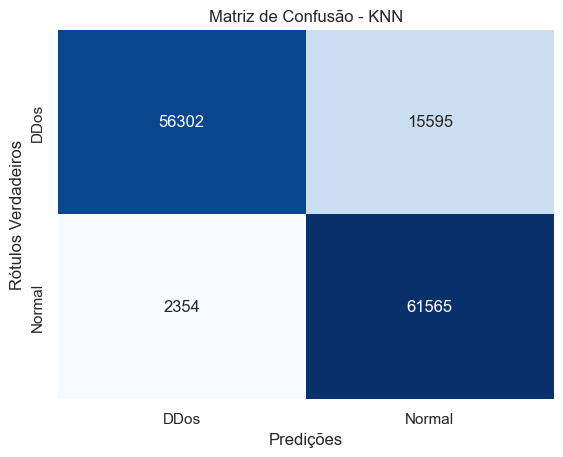

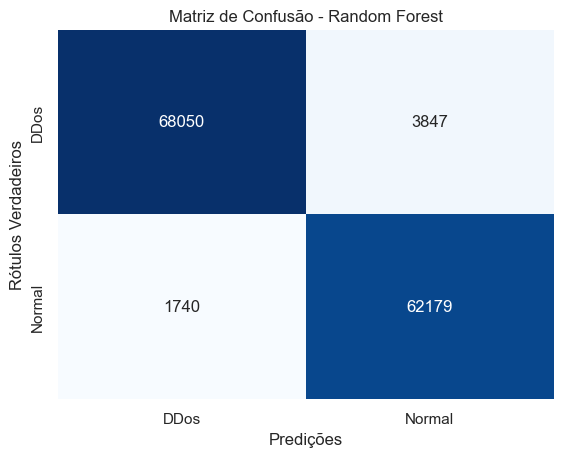

In [36]:
for name, model in models:
    predictions = model.predict(X_test, verbose=0) if (name == 'LSTM') else model.predict(X_test_trad)
    cm = confusion_matrix(y_test, predictions.flatten().round())

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['DDos', 'Normal'], yticklabels=['DDos', 'Normal'])

    # Adicionar rótulos aos eixos
    plt.xlabel('Predições')
    plt.ylabel('Rótulos Verdadeiros')
    plt.title(f'Matriz de Confusão - {name}')

    # Mostrar o gráfico
    plt.show()

## Acurácia

In [21]:
accuracy = []
names = []
for name, model in models:
    predictions = model.predict(X_test, verbose=0) if (name == 'LSTM') else model.predict(X_test_trad)
    accuracy.append(accuracy_score(y_test, predictions.flatten().round()))
    names.append(name)

[0.9567134947281616, 0.9881310007657419, 0.8678432585262413, 0.9588634623313895]


C:\Users\vitor\AppData\Local\Temp\ipykernel_9768\2744654004.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Acurácia', y='Modelo', data=dados, palette="Blues", orient='h')


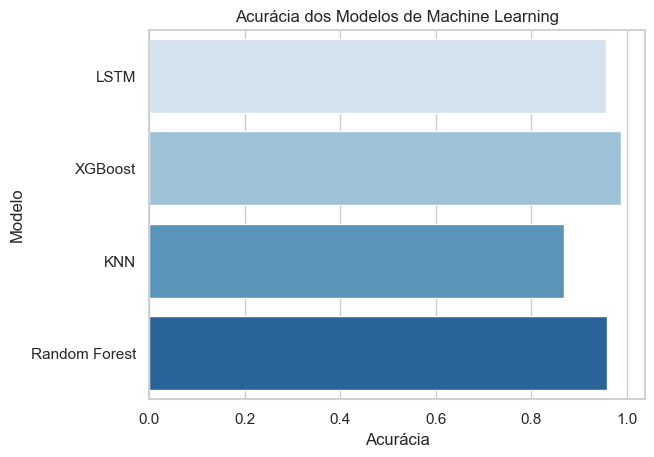

In [31]:
data  = dados = pd.DataFrame({'Modelo': names, 'Acurácia': accuracy})

sns.set(style="whitegrid")

# Criar um gráfico de barras horizontais
plt.figure()
ax = sns.barplot(x='Acurácia', y='Modelo', data=dados, palette="Blues", orient='h')

# Adicionar rótulos e título
plt.xlabel('Acurácia')
plt.ylabel('Modelo')
plt.title('Acurácia dos Modelos de Machine Learning')

# Exibir o gráfico
plt.show()

## Curva ROC E AUC

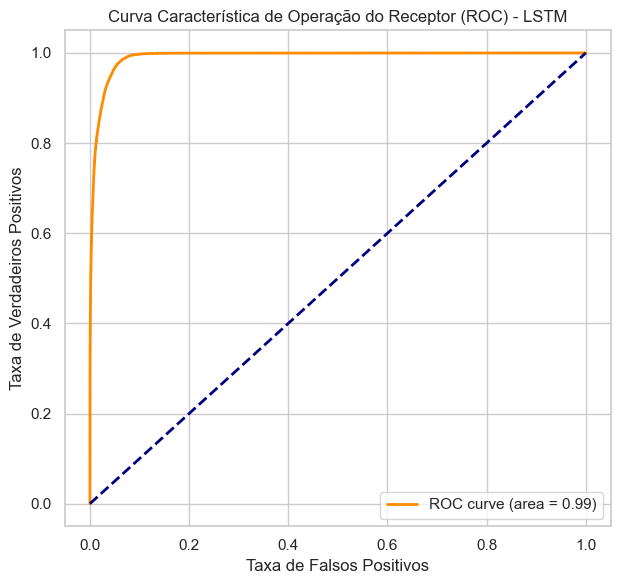

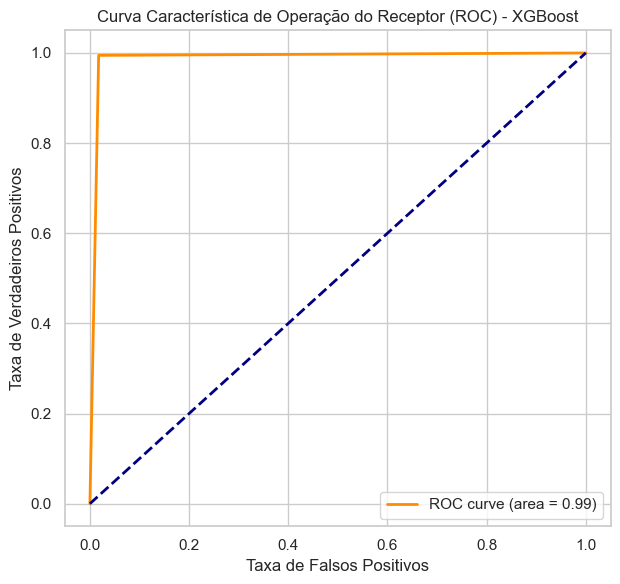

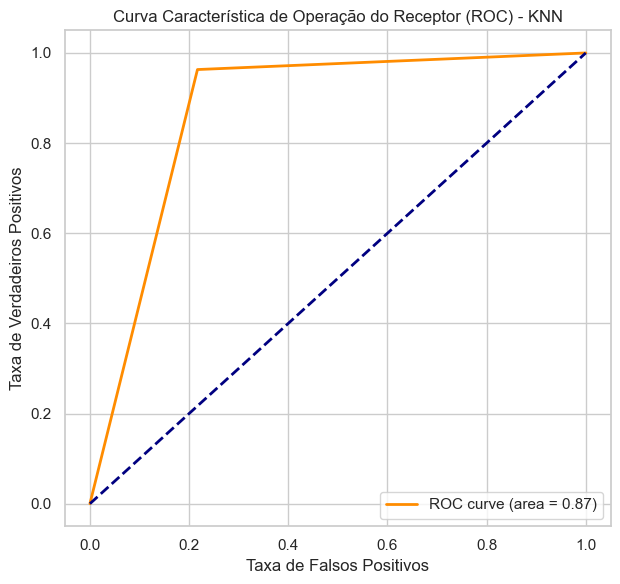

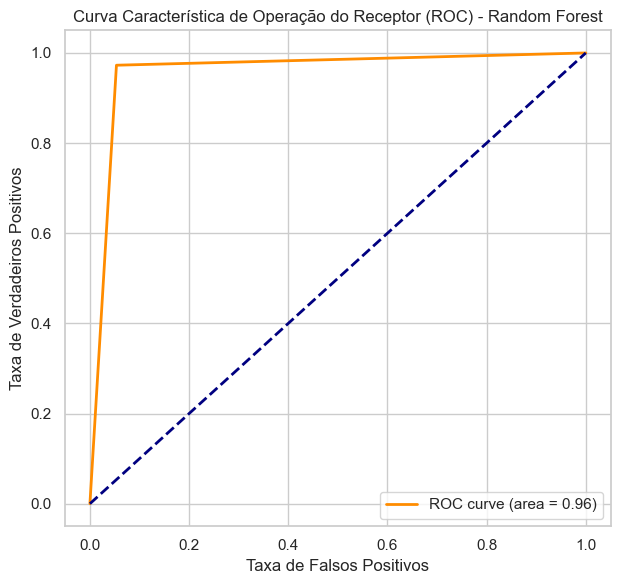

In [40]:
for name, model in models:
    predictions = model.predict(X_test, verbose=0) if (name == 'LSTM') else model.predict(X_test_trad)

    fpr, tpr, thresholds = roc_curve(y_test, predictions)

    # Calcule a área sob a curva (AUC)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva Característica de Operação do Receptor (ROC) - {name}')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()